What I've done so far

In [1]:
import geopandas as gpd
from glob import glob
import dask.dataframe as da
from dask.distributed import LocalCluster, Client
import matplotlib.pyplot as plt
import os
import rioxarray as rio
import xarray as xr
# from dem_utils import ArcticDEM
from tqdm import tqdm
import numpy as np
import pandas as pd
import numpy as np
from shapely import wkt
# import utils
import cartopy.crs as ccrs
import shapely
from rasterio.features import rasterize
from rasterio.enums import Resampling
import seaborn as sns
# import odc.geo.xr
from cycler import cycler
prj = ccrs.Stereographic(
    central_latitude=90,
    central_longitude=-45,
    true_scale_latitude=70
)
import itertools

In [2]:
# helper functions
def hexbin(x, y, color, **kwargs):
    # facetgrid hexbin func
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=30, cmap=cmap, **kwargs)
    

def demote_coords_to_vars(ds: xr.Dataset,
                        coords: str,
                        var_name: str):
    '''
    messy onliner to for reorganizing dataset.
    e.g. dataset with two variables: a (dims: x, y, t) and b (dims: x, y)
    this function will convert it to a dataset with 
    dimensions x, y and add as many `a` variables as there dim `t` is long
    '''
    return xr.merge([
        ds.drop_vars([coords, var_name]),
        xr.merge(
            [ds[var_name].isel({coords:i}).rename(ds[coords][i].item())
            for i in range(len(ds[coords]))], compat='override').drop_vars(coords)]
                    )

def add_geom_mask(ds, geom, buffer=200):
    # buffer geometry, with square ends
    buff_geom = geom.buffer(buffer, cap_style=3)
    
    # empty array of same x, y dim shape as merged
    arr = np.zeros((ds.sizes['y'], ds.sizes['x']))
    
    # rasterize
    burned = rasterize(shapes=[(buff_geom, 1)],
                       fill=0,
                       out=arr,
                       transform=ds.rio.transform())
    
    # merged rasterized with all other dataarrays
    merged = xr.merge([ds, xr.DataArray(data=burned,
                                        dims=['y','x'],
                                        coords={'y': ds.y,
                                                'x': ds.x}).rename('buffer_aoi')])

    return merged

class site():
    def __init__(self,
                 id: int,
                 vars: list=['sec', 'dem', 'sample', 'coreg_meta', 'stable_terrain', 'centreline']):
        
        '''
        convenience class for opening output files from directory id
        id = id number of study site directory
        vars = list of variables to include
        returns the opened files
        '''
        
        directories = glob('../data/id*')
        directory = [d for d in directories if f'id{id}' in d]
        assert len(directory) == 1, 'too many or not enough'
        self.directory = directory[0]

        self.paths = {
            'sec': os.path.join(self.directory, 'sec.zarr'),
            'dem': os.path.join(self.directory, 'stacked_coregd.zarr'),
            'sample': os.path.join(self.directory, 'sec_sample.parquet'),
            'coreg_meta': os.path.join(self.directory, 'coregistration_metadata.parquet'),
            'stable_terrain': os.path.join(self.directory, 'stable_terrain_mask.tif'),
            'centreline': os.path.join(self.directory, glob('line*.geojson', root_dir=self.directory)[0])
            }

        to_remove = []
        for k, v in self.paths.items():
            if os.path.exists(v):
                continue
            else:
                to_remove.append(k)
        
        [self.paths.pop(k) for k in to_remove]
                
        self.open_funcs = {
            '.tif': rio.open_rasterio,
            '.zarr': xr.open_zarr,
            '.parquet': pd.read_parquet,
            '.geojson': gpd.read_file
        }
        
        for var in [var for var in vars if var in self.paths.keys()]:
            _, extension = os.path.splitext(self.paths[var])
            setattr(self, var, self.open_funcs[extension](self.paths[var]))
        
        try:
            self.sec = demote_coords_to_vars(self.sec, 'result', 'sec')
        except:
            pass

def get_line(d):
    '''
    grab centreline from directory
    '''
    with open(f'{d}/download_notes.txt', 'r') as notes:
        notes = json.load(notes)
        return wkt.loads(notes['centreline'])

def get_ds(d):
    '''
    grab dem trend from directory
    '''
    _f = glob(f'{d}/coregistered/robust_spatial*.zarr')
    assert len(_f) == 1, 'not enough / too many .zarr dems'
    return xr.open_dataarray(_f[0], engine='zarr')

def sample_along_line(d):
    '''
    sample dhdt xarray along centreline
    '''
    ds = get_ds(d)
    line = get_line(d)
    points = [line.interpolate(x/100, normalized=True) for x in range(0,100)]
    distance = [line.project(p)/1000 for p in points]
    x = [p.x for p in points] 
    y = [p.y for p in points]
    df = pd.DataFrame({'distance (km)': distance,
                       'x': x,
                       'y': y})
    idx = df.set_index('distance (km)').to_xarray()
    return ds.interp(x=idx['x'],
                     y=idx['y'])

def plot_profile(d, ax):
    '''
    plot dhdt profile
    '''
    profile = sample_along_line(d)
    profile.sel(result='slope').plot(c='k',
                                     ax=ax)
    high = profile.sel(result='slope').max()
    low = profile.sel(result='slope').min()
    span = high - low
    ax.fill_between(profile['distance (km)'],
                    y1 = profile.sel(result='low_slope'),
                    y2 = profile.sel(result='high_slope'),
                    color='lightgrey',
                    alpha=0.8,
                    label="95% CI")
    ax.set_ylim(low - (high-low),
                high + (high-low))
    ax.set_ylabel('dh/dt (m/yr)')
    ax.legend(loc='upper left')
    ax.axhline(0, c='k', lw=0.5, zorder=0)
    ax.set_title(None)
    
def plot_xeqy(ax, c='gray'):
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ax.plot([max(minx, miny), (min(maxx, maxy))],
            [max(minx, miny), (min(maxx, maxy))], c=c, zorder=0)
    

def samples_groupby(samples, by=['where', 'region', 'lake_land', 'mid_bin']):
    '''
    group elevation samples by region/where/lake_land
    useful for plotting scatter of lake SEC vs. land SEC for different groupings
    e.g. symbolised by greenland/iceland (where) or by greenlandic region
    '''    
    lower = lambda x: np.quantile(x, 0.25)
    upper = lambda x: np.quantile(x, 0.75)

    ## add / remove region if needed
    slope_by_z = samples.groupby(by,
                                observed=True)['slope'].agg([lower,
                                                            upper,
                                                            'median']).reset_index()
    by.remove('lake_land')
    lake_land_df = pd.merge(
        slope_by_z.loc[slope_by_z['lake_land']=='land'].rename(columns={'<lambda_0>':'land_lower',
                                                                        '<lambda_1>':'land_upper',
                                                                        'median': 'land_median'}),
        slope_by_z.loc[slope_by_z['lake_land']=='lake'].rename(columns={'<lambda_0>':'lake_lower',
                                                                        '<lambda_1>':'lake_upper',
                                                                        'median': 'lake_median'}),
        left_on=by,
        right_on=by
        )

    ## nonsense for errorbars
    lake_land_df['land_low_err'] = lake_land_df['land_median'] - lake_land_df['land_lower']
    lake_land_df['land_up_err'] = lake_land_df['land_upper'] - lake_land_df['land_median']

    lake_land_df['lake_low_err'] = lake_land_df['lake_median'] - lake_land_df['lake_lower']
    lake_land_df['lake_up_err'] = lake_land_df['lake_upper'] - lake_land_df['lake_median']
    
    return lake_land_df


In [3]:
# basic inputs metadata
site_directories = glob('../data/id*')
site_directories.remove('../data/id32_1327449x_-2520905y')  # removing dodgy 32

centrelines = gpd.read_file('../data/streams_v3.geojson') # removing dodgy 32
centrelines = centrelines.loc[centrelines.index != 32]

basins = (gpd.read_file('../data/basins/Greenland_Basins_PS_v1.4.2.shp')
          .dissolve('SUBREGION1'))
centrelines = centrelines.sjoin(basins.drop(columns=['NAME', 'GL_TYPE']),
                                how='left'
                                ).rename(columns={'index_right': 'region'})


## Surface elevation change

** NOTE TO SELF: MANUALLY REMOVE `id32` AS THOSE RESULTS ARE CLEARLY JUNK **

### meta data

In [ ]:
# grab some meta data
dem_ids = []
dem_counts = []
useful_dem_counts = []
for d in site_directories:
    df= pd.read_parquet(
        os.path.join(d, 'coregistration_metadata.parquet')
        )
    dem_ids += df['to_reg_dem_id'].unique().tolist()
    dem_counts.append(len(df['to_reg_dem_id'].unique()))
    useful_dem_counts.append(((df['nmad_after'] < 2) & (df['median_after'].abs() < 1)).sum())

In [ ]:
# show the meta data
print('number of study sites, by location and type')
print(centrelines.groupby(['where', 'lake_land'])['geometry'].count().to_markdown())

print(centrelines.groupby(['where', 'region', 'lake_land'])['geometry'].count().to_markdown())

print(f'\ntotal of {len(dem_ids)} _sections_ of DEMs used and coregistered (total of: {len(set(dem_ids))} tiles)')
print(f'each of the 36 study sites on average used {np.mean(dem_counts):.0f}'
      f'(mean) {np.median(dem_counts):.0f} (median) DEMs.',
      '\n(where used means coregistered)\n')

print('Coregistered DEMs were removed from subsequent analyses if they '
      'failed to meet NMAD and MDOST of 2 m and ±1 m, respectively')
print(f'the site with the fewest/most DEMs used {np.min(useful_dem_counts):.0f}/{np.max(useful_dem_counts):.0f}. '
      f'mean/median: {np.mean(useful_dem_counts):.0f}/{np.median(useful_dem_counts):.0f}')

In [6]:
# read the coregistration metadata
dfs = []
for d in site_directories:
    df = pd.read_parquet(
        os.path.join(d, 'coregistration_metadata.parquet')
        )
    
    ls_path = glob('line_*.geojson', root_dir=d)
    assert len(ls_path)==1, 'oops'
    ls = gpd.read_file(
        os.path.join(d, ls_path[0])
    )
    
    df['where'] = ls.loc[0, 'where']
    df['lake_land'] = ls.loc[0, 'lake_land']
    df['id'] = int(d.split('_')[0].split('id')[-1])
    dfs.append(df)
    
coreg_meta = pd.concat(dfs)

In [ ]:
## plot to coregistration metadata
fig, axs = plt.subplots(ncols=2, figsize=[8,4])

# MEDIAN
sns.scatterplot(data=coreg_meta,
                x='median_after',
                y='median_before',
                hue='lake_land',
                style='where',
                s=10,
                markers=['o','s'],
                ax=axs[0],
                legend=False)

axs[0].set(xlim=(-5, 5),
       ylim=(-22, 25)
)
axs[0].axhline(0, c='gray', zorder=0, lw=0.5)
axs[0].axvline(0, c='gray', zorder=0, lw=0.5)
plot_xeqy(axs[0])

axs[0].fill_between([-5, -1], -22, 25, color='lightgray', alpha=0.5)
axs[0].fill_between([1, 5], -22, 25, color='lightgray', alpha=0.5)

axs[0].set_title('Medians')

## NMAD
sns.scatterplot(data=coreg_meta,
                x='nmad_after',
                y='nmad_before',
                hue='lake_land',
                style='where',
                s=10,
                markers=['o','s'],
                ax=axs[1],
                legend=False)

axs[1].set(xlim=(0, 5),
           ylim=(0, 7.5)
)
plot_xeqy(axs[1])
axs[1].fill_between([2, 7.5], 0, 7.5, color='lightgray', alpha=0.5)
axs[1].set_title('NMAD')

plt.subplots_adjust(wspace=0.25)

### results

Buffered each centreline by 200 m and extracted rates of SEC for all gridsquares in buffered region along with the _median_ elevation from the stack of coregistered DEMs.

Plot of elevation against rate of SEC by Greenland/Iceland and lake/land.

In [ ]:
## read in sample files, and assign basin SUBREGION

sample_files = glob('../data/id*/sec_sample.parquet')
sample_files.remove('../data/id32_1327449x_-2520905y/sec_sample.parquet')  # removing dodgy 32!

# read in all sample files
samples = pd.concat(
    [pd.read_parquet(sf) for sf in sample_files]
)
# add greenland basin region to samples
samples['id'] = samples['id'].astype(int)
samples = samples.merge(centrelines['region'], left_on='id', right_index=True)

print(f'there are {len(samples)} sample points in total\nand by where/type the breakdown is:')
print(samples.groupby(['where','lake_land'])['z_median'].count().to_markdown())
print(samples.groupby(['where', 'region', 'lake_land'])['z_median'].count().to_markdown())

In [ ]:
# SEC against elevation by lake/land and greenland basin
fg = sns.FacetGrid(samples.loc[samples['where']=='greenland'],
                    col='region',
                    row='lake_land',
                    hue='lake_land',
                    hue_order=['lake', 'land'],
                    row_order=['lake', 'land'],
                    col_order=centrelines['region'].value_counts().index.tolist()
)
fg.map(hexbin, "slope", "z_median", extent=[-10,5,0,1600])

for ax in fg.axes.flat:
    t = ax.get_title()
    t = t.replace('region = ', "").replace('lake_land = ', "")
    ax.set_title(t)
    ax.axvline(0, c='k', lw=0.5)

fg.set(xlabel='Surface elevation change (m/yr)',
       ylabel='Elevation (m)')

In [ ]:
# SEC against elevation by lake/land and greenland/iceland

fg = sns.FacetGrid(samples,
                    row='where',
                    col='lake_land',
                    hue='lake_land',
                    hue_order=['lake', 'land'],
                    row_order=['greenland', 'iceland'],
                    col_order=['lake', 'land'],
)
fg.map(hexbin, "slope", "z_median", extent=[-10,5,0,1600])

for ax in fg.axes.flat:
    t = ax.get_title()
    t = t.replace('where = ', "").replace('lake_land = ', "")
    ax.set_title(t.title())
    ax.axvline(0, c='k', lw=0.5)

fg.set(xlabel='Surface elevation change (m/yr)',
       ylabel='Elevation (m)')

- bin elevations into 20 m (or 50 or whatever) wide buckets
- group all the samples by:
    - mid value of this bucket
    - iceland / greenland
    - greenland region
    - lake / land
- for each group compute the median, lower quartile and upper quartile of the rates of SEC

for compatability with `plt.errorbar()` need to add/subtract the upper/lower quartiles from the median

In [8]:
# bin elevations
bin_width = 25
samples['z_bins'] = pd.cut(samples['z_median'], np.arange(12.5, 1812.5, bin_width))
samples['mid_bin'] = samples['z_bins'].apply(lambda x: int(x.mid)).astype(int)

In [ ]:
# scatter of lake vs land SEC for GREENLAND ONLY, coloured by elevation, symbolised by region
lake_land_df = samples_groupby(samples, ['where', 'region', 'lake_land', 'mid_bin'])

# plotting
fig, ax = plt.subplots(figsize=[8,8])
sns.scatterplot(data=lake_land_df.loc[lake_land_df['where']=='greenland'],
                x='lake_median',
                y='land_median',
                style='region',
              #   markers=['o','s'],
                hue='mid_bin',
                palette='Blues',
                ec='k',
                ax=ax,
                legend="full",
                )

# quick sort of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-4:], labels[-4:])

ax.errorbar(x='lake_median',
            y='land_median',
            yerr=np.c_[lake_land_df['land_low_err'].values,
                       lake_land_df['land_up_err'].values].T,
            xerr=np.c_[lake_land_df['lake_low_err'].values,
                       lake_land_df['lake_up_err'].values].T,
            data=lake_land_df,
            fmt='none',
            ecolor='lightgray',
            elinewidth=0.5,
            zorder=0)

# limits and aspect ratio and x=y line
ax.set(
  xlim=(-7.5, 0.5),
  ylim=(-7.5, 0.5),
  xlabel='Lakes : Surface elevation change (m/yr)',
  ylabel='Land : Surface elevation change (m/yr)')
ax.set_aspect('equal')

ax.annotate(f'elevation bin width: {bin_width} m',
            xy=(0.99, 0.01),
            ha='right',
            xycoords='axes fraction')

plot_xeqy(ax)


########## elevation colorbar
norm = plt.Normalize(*lake_land_df['mid_bin'].agg(['min', 'max']))
cmap = plt.get_cmap('Blues')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

pos = ax.get_position()
cax = fig.add_axes([pos.x1 + 0.01,
                    pos.y0,
                    0.03,
                    pos.height])

cb = plt.colorbar(sm, cax=cax)
cax.set_ylabel('Elevation (m)')

In [ ]:
lake_land_df['diff_lake_sub_land'] = lake_land_df['lake_median'] - lake_land_df['land_median']

ax = sns.histplot(data=lake_land_df,
                 x='diff_lake_sub_land',
                 hue='region',
                #  palette=['tab:green', 'tab:pink'],
                 binwidth=0.2,
                 multiple='stack'
                 )

ax.axvline(0, c='k', zorder=0, lw=2, ls=':')

ax.set_xlabel('<--- more thinning at lake <---| lake SEC - land SEC |---> more thinning at land --->')

In [ ]:
# fig, ax = plt.subplots()
fg = sns.displot(samples.loc[samples['where']=='greenland'].sample(1000),
                 x='slope',
                 hue='region',
                 common_norm=False,
                 kind='kde',
                 col='lake_land',
                 col_order=['lake', 'land'])

fg.set(ylim=(0, 1.5),
       xlim=(-5, 5),
       xlabel=('SEC (m/yr)'))

for ax in fg.axes.flat:
    ax.axvline(0, c='gray', lw=0.5)

In [ ]:
# scatter of lake vs land SEC for coloured by elevation, symbolised by greenland/iceland

lake_land_df = samples_groupby(samples, ['where', 'lake_land', 'mid_bin'])

fig, ax = plt.subplots(figsize=[8,8])
sns.scatterplot(data=lake_land_df,
                x='lake_median',
                y='land_median',
                style='where',
                markers=['o','s'],
                hue='mid_bin',
                palette='Blues',
                ec='k',
                ax=ax,
                legend='brief'
                )

# quick sort of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:])

ax.errorbar(x='lake_median',
            y='land_median',
            yerr=np.c_[lake_land_df['land_low_err'].values,
                       lake_land_df['land_up_err'].values].T,
            xerr=np.c_[lake_land_df['lake_low_err'].values,
                       lake_land_df['lake_up_err'].values].T,
            data=lake_land_df,
            fmt='none',
            ecolor='lightgray',
            elinewidth=0.5,
            zorder=0)

# limits and aspect ratio and x=y line
ax.set(xlim=(-6, 0.5),
       ylim=(-6, 0.5),
       xlabel='Lakes : Surface elevation change (m/yr)',
       ylabel='Land : Surface elevation change (m/yr)')
ax.set_aspect('equal')
plot_xeqy(ax)

ax.annotate(f'elevation bin width: {bin_width} m',
            xy=(0.99, 0.01),
            ha='right',
            xycoords='axes fraction')

########## elevation colorbar
norm = plt.Normalize(*lake_land_df['mid_bin'].agg(['min', 'max']))
cmap = plt.get_cmap('Blues')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

pos = ax.get_position()
cax = fig.add_axes([pos.x1 + 0.01,
                    pos.y0,
                    0.03,
                    pos.height])

cb = plt.colorbar(sm, cax=cax)
cax.set_ylabel('Elevation (m)')

## velocity

### results

In [54]:
v_zarrs = glob('../results/intermediate/velocity/robust_annual_trends/*')
zarr_dict = dict(
    zip(
        [int(os.path.basename(z).split('_')[0].split('id')[-1]) for z in v_zarrs],
        v_zarrs
    ))
grps = centrelines.groupby(['where', 'lake_land', 'region'])
group = list(grps.groups.keys())
gidx = list(grps.groups.values())

def sample_along_line(d):
    '''
    sample dhdt xarray along centreline
    '''
    ds = get_ds(d)
    line = get_line(d)
    points = [line.interpolate(x/100, normalized=True) for x in range(0,100)]
    distance = [line.project(p)/1000 for p in points]
    x = [p.x for p in points] 
    y = [p.y for p in points]
    df = pd.DataFrame({'distance (km)': distance,
                       'x': x,
                       'y': y})
    idx = df.set_index('distance (km)').to_xarray()
    return ds.interp(x=idx['x'],
                     y=idx['y'])
    
def sample_along_line(vds):
    cl = wkt.loads(vds.attrs['centreline'])
    length = cl.length
    points = [cl.interpolate(x) for x in np.arange(0, length+250, 250)]
    distance = [cl.project(p)/1000 for p in points]
    x = [p.x for p in points]
    y = [p.y for p in points]
    df = pd.DataFrame({'distance (km)': distance,
                       'x': x,
                       'y': y})
    idx = df.set_index('distance (km)').to_xarray()
    return vds.interp(x=idx['x'],
                      y=idx['y'])
    
    
ldfs = []
for k, v in grps.groups.items():
    zarr_files = [zarr_dict[z] for z in v if z in zarr_dict.keys()]
    # print(k, v, zarr_files)
    
    for id, zarr in zip(v, zarr_files):
        # print(id, zarr)
        2+2
        with xr.open_zarr(zarr)['v_trend'] as ds:
            ldf = (sample_along_line(ds)
                   .drop_vars(['mapping','x','y'])
                   .to_dataframe()
                   .unstack('result')['v_trend']
                   .reset_index())
            ldf['where'] = k[0]
            ldf['lake_land'] = k[1]
            ldf['region'] = k[2]
            ldf['id'] = id
            ldf['distance (km)'] = ldf['distance (km)'].round(2)
            ldfs.append(ldf)

line_df = pd.concat(ldfs).reset_index(drop=True)

In [ ]:
# spread of velocity trends in greenland
fg = sns.relplot(line_df.loc[line_df['where']=='greenland'],
                 x='distance (km)',
                 y='slope',
                 hue='region',
                 col='lake_land',
                 estimator='mean',
                 errorbar='sd',
                 kind='line')

fg.map(plt.axhline, y=0, c='gray', lw=0.5)
fg.set(xlim=(-0.25, 10.25),
       xlabel='Distance from terminus (km)',
       ylabel='Velocity trend (m/yr^-2)')

for ax in fg.axes.flat:
    t = ax.get_title()
    ax.set_title(t.replace('lake_land = ', '').title())

In [ ]:
line_df_split = samples_groupby(line_df, by=['where', 'region', 'lake_land', 'distance (km)'])
# scatter of lake vs land SEC for GREENLAND ONLY, coloured by elevation, symbolised by region

# plotting
fig, ax = plt.subplots(figsize=[8,8])
sns.scatterplot(data=line_df_split.loc[line_df_split['where']=='greenland'],
                x='lake_median',
                y='land_median',
                style='region',
              #   markers=['o','s'],
                hue='distance (km)',
                palette='Blues',
                ec='k',
                ax=ax,
                legend="full",
                )

# quick sort of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:])

ax.errorbar(x='lake_median',
            y='land_median',
            yerr=np.c_[line_df_split['land_low_err'].values,
                       line_df_split['land_up_err'].values].T,
            xerr=np.c_[line_df_split['lake_low_err'].values,
                       line_df_split['lake_up_err'].values].T,
            data=line_df_split,
            fmt='none',
            ecolor='lightgray',
            elinewidth=0.5,
            zorder=0)

# limits and aspect ratio and x=y line
ax.set(
  xlim=(-4, 1.5),
  ylim=(-4, 1.5),
  xlabel='Lakes : Velocity trend (m yr^-2)',
  ylabel='Land : Velocity trend (m yr^-2)')
ax.set_aspect('equal')

# ax.annotate(f'elevation bin width: {bin_width} m',
#             xy=(0.99, 0.01),
#             ha='right',
#             xycoords='axes fraction')

plot_xeqy(ax)


########## elevation colorbar
norm = plt.Normalize(*line_df_split['distance (km)'].agg(['min', 'max']))
cmap = plt.get_cmap('Blues')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

pos = ax.get_position()
cax = fig.add_axes([pos.x1 + 0.01,
                    pos.y0,
                    0.03,
                    pos.height])

cb = plt.colorbar(sm, cax=cax)
cax.set_ylabel('Distance from terminus (km)')

### fixing centreliner

In [29]:
from scipy.stats import theilslopes
import utils
import dask
from velocity_utils import CentreLiner, Tools

In [30]:
V = CentreLiner(geo=centrelines.loc[10, 'geometry'],
                buff_dist=3000,
                index=10,
                filter=True,
                get_robust_trend=False,
                get_annual_median=False,
                sample_centreline=True,
                get_rgb=False,
                **{'ddt_range': [pd.Timedelta(td) for td in ('335d', '395d')],
                   'middate_range': (pd.to_datetime('2010-01-01'),
                                     pd.Timestamp.now()),
                   })

getting cubes from itslive


In [211]:
q = [0.25, 0.5, 0.75, 0.9]
def quantiles(arr):
    return np.nanquantile(arr, q, axis=-1)

out = xr.apply_ufunc(
    quantiles,
    ds,
    input_core_dims=[['mid_date']],
    output_core_dims=[['quartiles']],
    vectorize=True,
    dask='parallelized',
    dask_gufunc_kwargs={
        'allow_rechunk': True,
        'output_sizes': {'quartiles': len(q)},
    },
    output_dtypes=[float],   
)
out = out.assign_coords(quartiles=q)


In [216]:
def get_annual_quantiles(self,
                         qs=[0.25, 0.5, 0.75]):
    '''
    groups by year of mid_date and computes median
    of velocity field.
    gets median of **filtered** velocities. which
    means that this median is not equal to the same median
    that is used when doing the outlier detections
    median calculated for each [filtered] velocity cube
    this gives them a common `year` index, along which they can
    be aligned with xr.merge so this returns a single dataset

    inputs: vars - list of variables to apply median to
    defaults to ['v', 'vx', 'vy'] as the component medians
    are used for constructing flow lines

    returns median dataset (self.median)
    '''
    def quartiles(arr):
        return np.nanquantile(arr, qs, axis=-1)
    
    q_dss = []
    for ds in self.filtered_v:
        _q_ds = xr.apply_ufunc(
            quartiles,
            ds,
            input_core_dims=[['mid_date']],
            output_core_dims=[['q']],
            vectorize=True,
            dask='parallelized',
            dask_gufunc_kwargs={
                'allow_rechunk': True,
                'output_sizes': {'q': len(qs)}
            },
            output_dtypes=[float]
        )
        
        _q_ds = _q_ds.assign_coords(q=qs)
        q_dss.append(_q_ds)
        
    self.q_v = xr.merge(q_dss)

In [217]:
get_annual_quantiles(V)

In [227]:
[q.sizes for q in V.filtered_v]

[Frozen({'mid_date': 33589, 'x': 39, 'y': 128}),
 Frozen({'mid_date': 28427, 'x': 26, 'y': 128})]

In [231]:
norm = plt.Normalize(V.q_v['v'].min().compute(),
                     V.q_v['v'].max().compute())
cmap = plt.get_cmap('viridis')

In [232]:
V.q_v.q

<xarray.DataArray 'q' (q: 3)> Size: 24B
array([0.25, 0.5 , 0.75])
Coordinates:
  * q        (q) float64 24B 0.25 0.5 0.75
    mapping  int64 8B 0

In [236]:
ds = V.filtered_v[0]

In [ ]:
ds.chunk({'mid_date':-1}).groupby(ds.mid_date.dt.year).quantile([0.25, 0.5, 0.75], dim='mid_date')

<xarray.Dataset> Size: 3MB
Dimensions:   (year: 13, quantile: 2, y: 128, x: 39)
Coordinates:
  * x         (x) float64 312B 4.954e+05 4.955e+05 4.957e+05 ... 4.999e+05 5e+05
  * y         (y) float64 1kB -1.344e+06 -1.344e+06 ... -1.359e+06 -1.359e+06
  * quantile  (quantile) float64 16B 0.25 0.5
  * year      (year) int64 104B 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022
Data variables:
    vx        (year, quantile, y, x) float64 1MB dask.array<chunksize=(1, 2, 16, 6), meta=np.ndarray>
    vy        (year, quantile, y, x) float64 1MB dask.array<chunksize=(1, 2, 16, 6), meta=np.ndarray>
    v         (year, quantile, y, x) float64 1MB dask.array<chunksize=(1, 2, 16, 6), meta=np.ndarray>

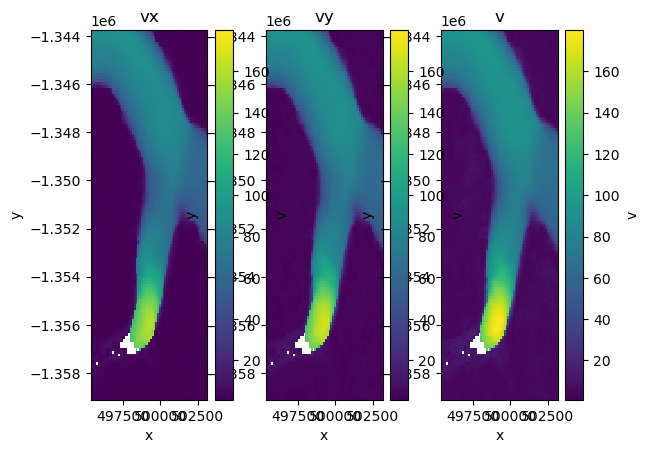

In [234]:
fig, axs = plt.subplots(ncols=3)

for i, q in enumerate(V.q_v):
    V.q_v['v'][:,:,i].plot(ax=axs[i],
                      cmap=cmap,
                      norm=norm)
    axs[i].set_title(q)

In [175]:
quantiles[0][:,:,0].plot()

ValueError: 0-dimensional argument does not have enough dimensions for all core dimensions ('dim1',)

In [157]:
quantiles[:,:,0].plot()

ValueError: 0-dimensional argument does not have enough dimensions for all core dimensions ('dim1',)

In [ ]:
xr.concat(qs, dim='')

TypeError: concat() missing 1 required positional argument: 'dim'

In [78]:
ds['v'].groupby(ds.mid_date.dt.year).quantile(0.25,
                                              dask_gufunc_kwargs={'allow_rechunk': True})

TypeError: GroupBy.quantile() got an unexpected keyword argument 'dask_gufunc_kwargs'

In [ ]:
vars = ['v', 'vx', 'vy']
medians = []
interqs = []
counts = []

medians.append(ds[vars]
               .groupby(ds.mid_date.dt.year)
               .median())

medians

